In [1]:
import pandas as pd
# pd.options.display.float_format = '{:.3f}'.format
# pd.reset_option('display.float_format')

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sqlalchemy import create_engine

from tqdm.notebook import tqdm

import time, os

import pickle

In [2]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [3]:
import xgboost as xgb

In [4]:
cnx = create_engine('postgresql://ubuntu@18.191.26.249:5432/covid19mx')

In [5]:
df  = pd.read_sql_query('''
    SELECT 
        ( SELECT max(admissiondate) FROM covid19 ) - symptomdate AS symptom,
        admissiondate - symptomdate AS admission,
        institutionstateid != stateid AS moved,
        deathdate IS NOT NULL AS died ,
        (SELECT institution FROM institution WHERE institution.id = sectorid) AS institution,
        states.wiki AS institution_state,
        (SELECT wiki FROM states WHERE states.id = stateid) AS state,
        ( genderid = 1 )          AS male,
        ( patienttypeid =1 )      AS hospitalized,
        ( intubated = 1 )         AS intubated_yes,
        ( intubated = 2 )         AS intubated_no,
        ( pneumonia = 1 )         AS pneumonia,
        age,
        ( nationality = 2)        AS foreigner,
        ( diabetes = 1 )          AS diabetes,
        ( copd = 1 )              AS copd,
        ( asthma = 1 )            AS asthma,
        ( immunosuppression = 1 ) AS immunosuppression,
        ( hypertension = 1 )      AS hypertension,
        ( otherdiseases = 1 )     AS otherdiseases,
        ( cardiovascular = 1 )    AS cardiovascular,
        ( obesity = 1 )           AS obesity,
        ( renal = 1 )             AS renal,
        ( tobacco = 1 )           AS tobacco,
        ( contactwithcovid = 1)   AS covid_contact_yes,
        ( contactwithcovid = 2)   AS covid_contact_no,
        testresult,
        "GDP"."GDP",
        "GDP_per_cap"."perCapita",
        "HDI"."2017" AS "HDI",
        pop_density."Population",
        pop_density."PopulationDensity",
        pop_density."Area",
        poverty_rate."PovertyRate" 
    FROM covid19 c 
        LEFT JOIN states ON c.institutionstateid = states.id 
        LEFT JOIN "GDP" ON states.wiki = "GDP"."State" 
        LEFT JOIN "GDP_per_cap" ON states.wiki = "GDP_per_cap"."State" 
        LEFT JOIN "HDI" ON states.state = upper( "HDI"."Federal Entity" )
        LEFT JOIN pop_density ON states.wiki = pop_density."State" 
        LEFT JOIN poverty_rate ON states.wiki = poverty_rate."State" 
    WHERE 
        NOT (
            diabetes = 98 AND 
            copd = 98 AND 
            asthma = 98 AND 
            immunosuppression = 98 AND 
            hypertension = 98 AND 
            otherdiseases = 98 AND 
            cardiovascular = 98 AND 
            obesity = 98 AND 
            tobacco = 98 AND 
            renal = 98
        )
    ''', cnx, parse_dates=['admissiondate','symptomdate','deathdate'])
df.nunique()

symptom              126
admission             56
moved                  2
died                   2
institution           13
institution_state     32
state                 32
male                   2
hospitalized           2
intubated_yes          2
intubated_no           2
pneumonia              2
age                  105
foreigner              2
diabetes               2
copd                   2
asthma                 2
immunosuppression      2
hypertension           2
otherdiseases          2
cardiovascular         2
obesity                2
renal                  2
tobacco                2
covid_contact_yes      2
covid_contact_no       2
testresult             3
GDP                   32
perCapita             32
HDI                   27
Population            32
PopulationDensity     31
Area                  32
PovertyRate           32
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105356 entries, 0 to 105355
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   symptom            105356 non-null  int64  
 1   admission          105356 non-null  int64  
 2   moved              105356 non-null  bool   
 3   died               105356 non-null  bool   
 4   institution        105356 non-null  object 
 5   institution_state  105356 non-null  object 
 6   state              105356 non-null  object 
 7   male               105356 non-null  bool   
 8   hospitalized       105356 non-null  bool   
 9   intubated_yes      105356 non-null  bool   
 10  intubated_no       105356 non-null  bool   
 11  pneumonia          105356 non-null  bool   
 12  age                105356 non-null  int64  
 13  foreigner          105356 non-null  bool   
 14  diabetes           105356 non-null  bool   
 15  copd               105356 non-null  bool   
 16  as

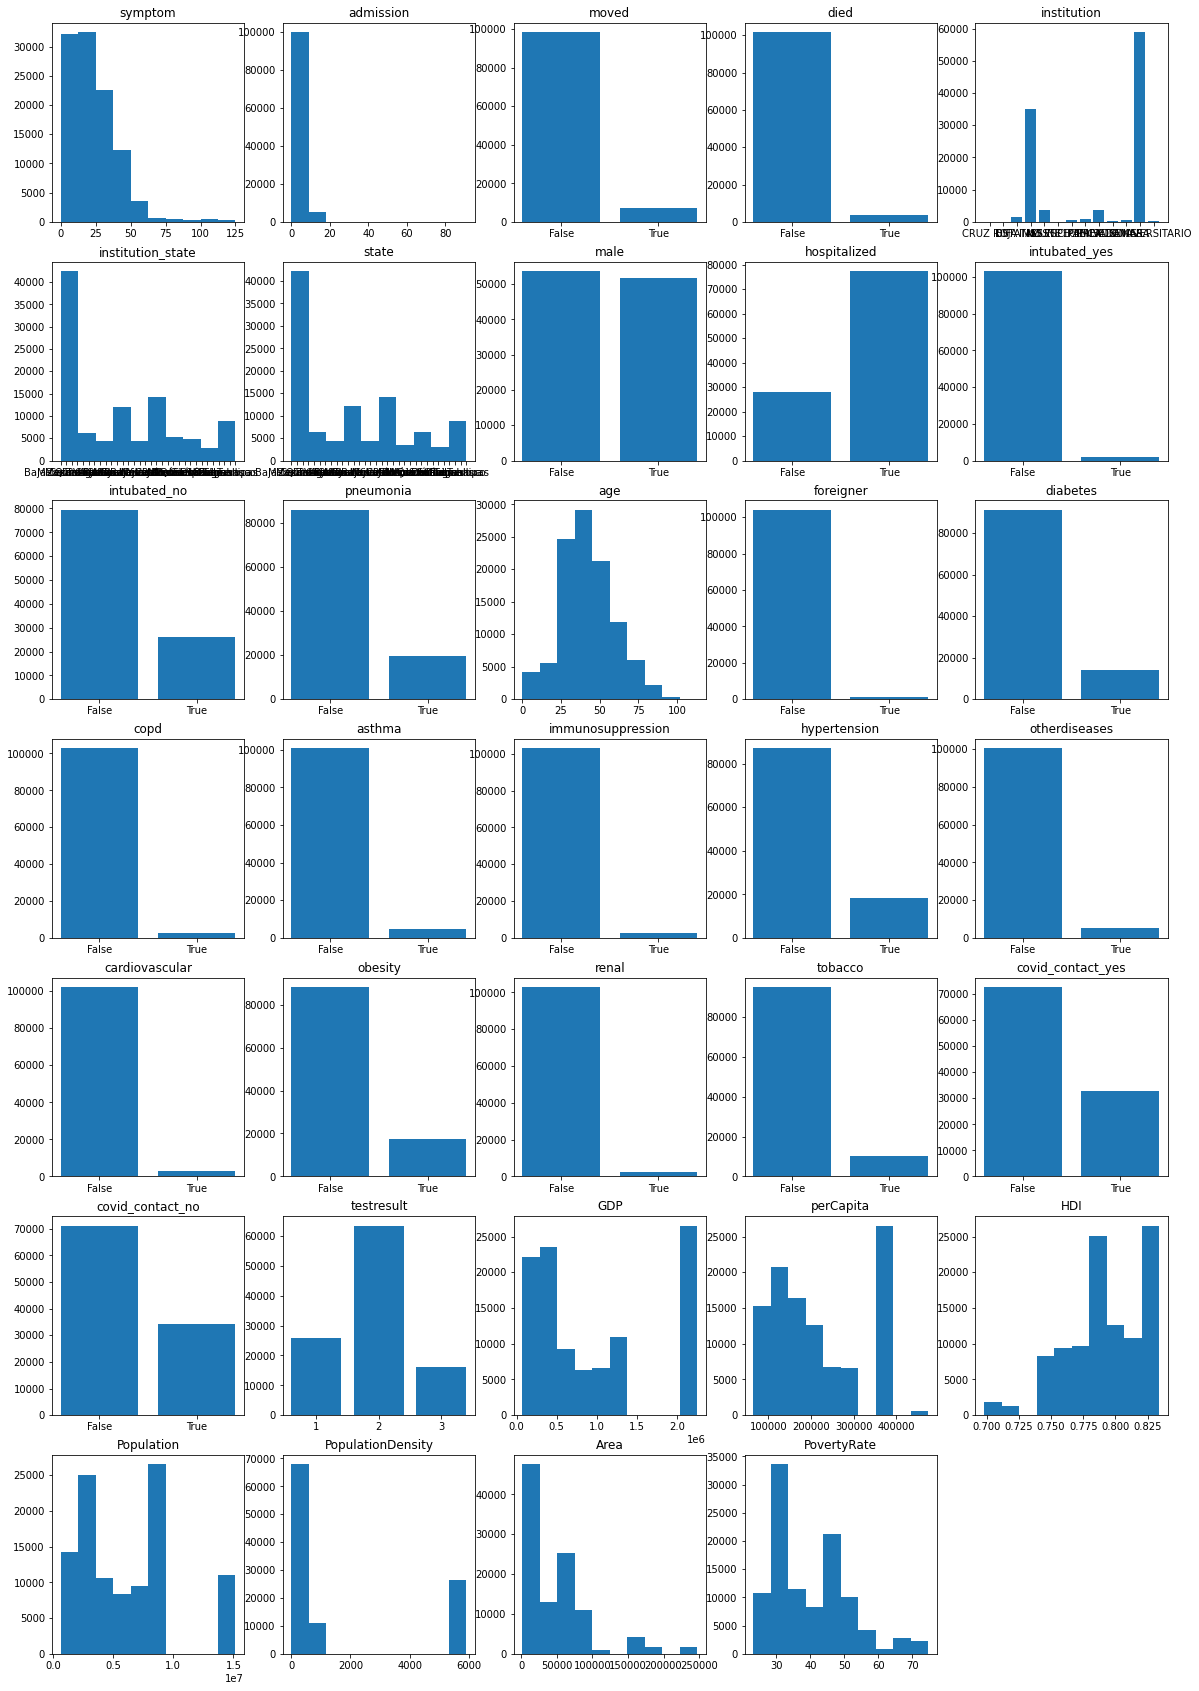

In [8]:
fig = plt.figure(figsize = (20,30))
for i in range(0,len(df.columns)):
    plt.subplot(7,5,i+1)
    value_counts = df.iloc[:,i].value_counts().sort_index()
    plt.title(df.columns[i])
    if len(value_counts) < 20 :
        plt.bar(value_counts.index.astype(str),value_counts)
    else:
        plt.hist(df.iloc[:,i].dropna())

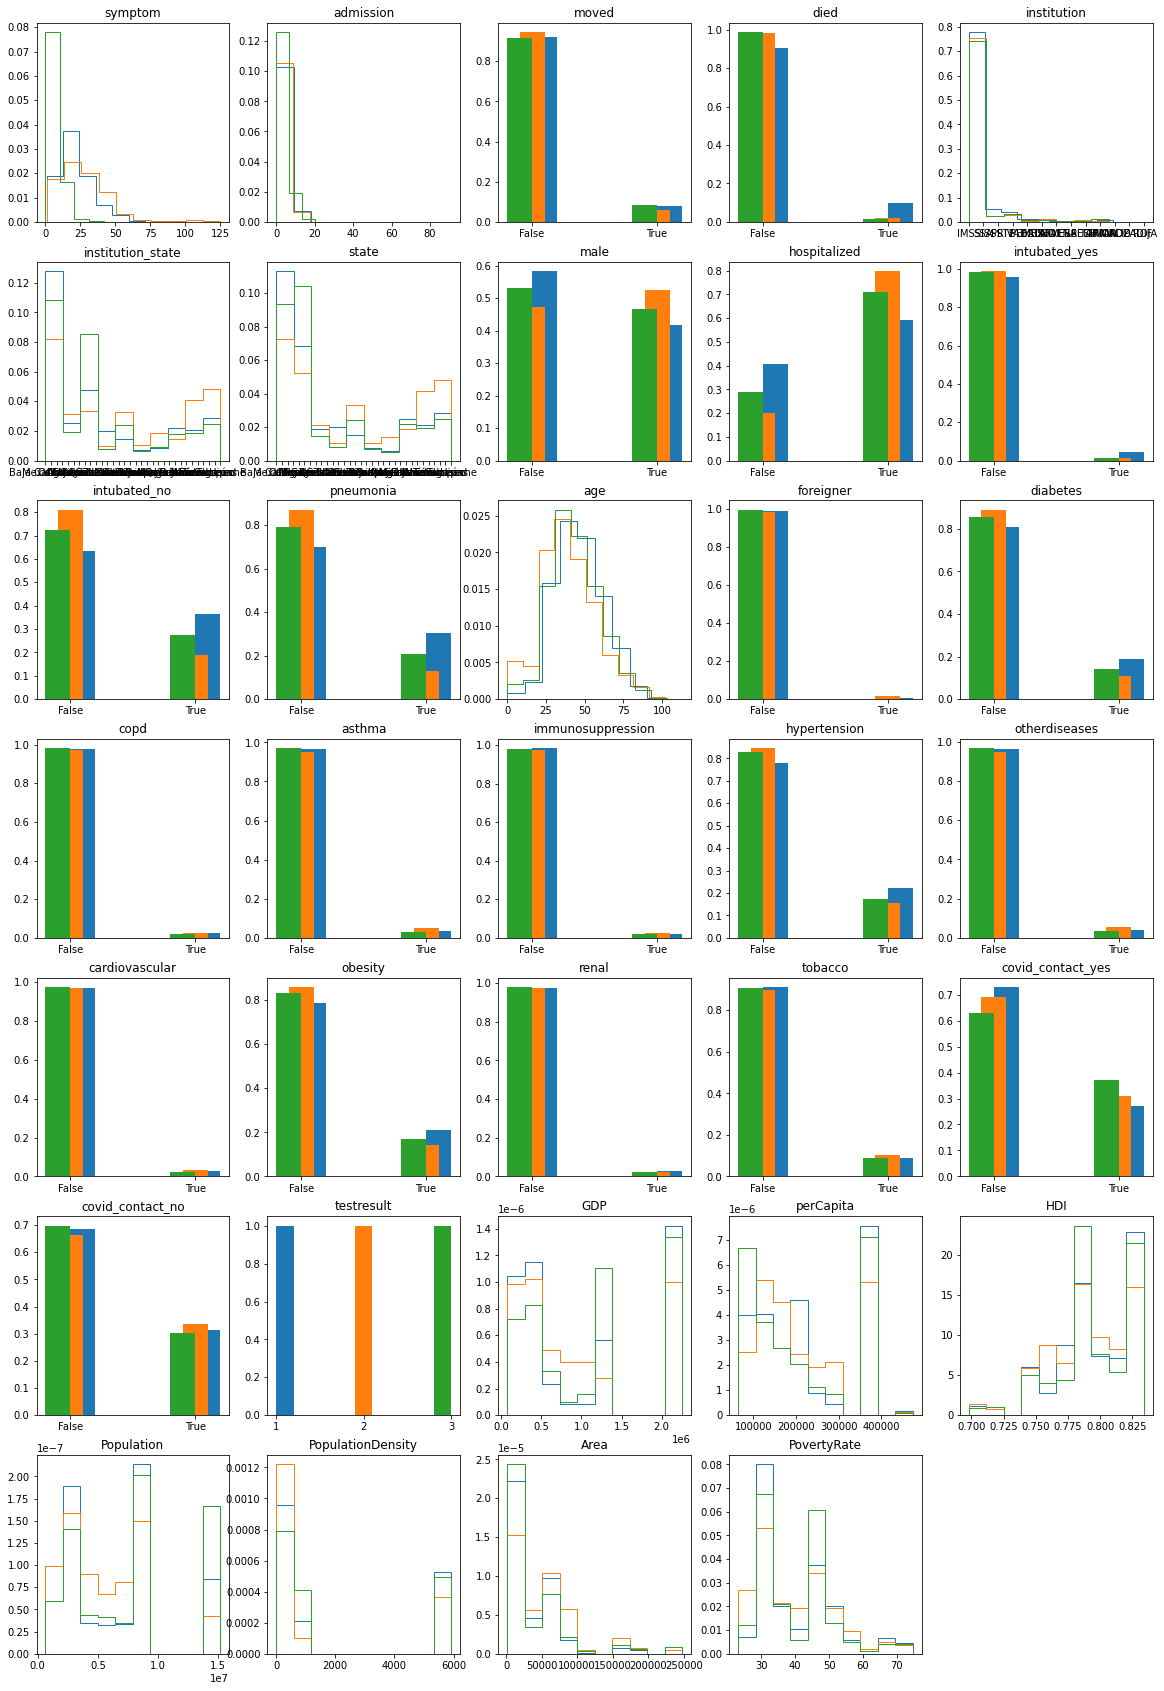

In [9]:
fig = plt.figure(figsize = (20,30))
for i in range(0,len(df.columns)):
    plt.subplot(7,5,i+1)
    value_counts_pos = df[df.testresult==1].iloc[:,i].value_counts().sort_index() / len(df[df.testresult==1])
    value_counts_neg = df[df.testresult==2].iloc[:,i].value_counts().sort_index() / len(df[df.testresult==2])
    value_counts_ped = df[df.testresult==3].iloc[:,i].value_counts().sort_index() / len(df[df.testresult==3])
    plt.title(df.columns[i])
    if len(value_counts_neg) < 10 :
        plt.bar(value_counts_pos.index.astype(str),value_counts_pos,align="edge", width = .2)
        plt.bar(value_counts_neg.index.astype(str),value_counts_neg, width = .2)
        plt.bar(value_counts_ped.index.astype(str),value_counts_ped,align="edge", width = -.2)
    else:
        plt.hist(df[df.testresult==1].iloc[:,i].dropna(), histtype = "step" ,density=True)
        plt.hist(df[df.testresult==2].iloc[:,i].dropna(), histtype = "step" ,density=True)
        plt.hist(df[df.testresult==3].iloc[:,i].dropna(), histtype = "step" ,density=True)

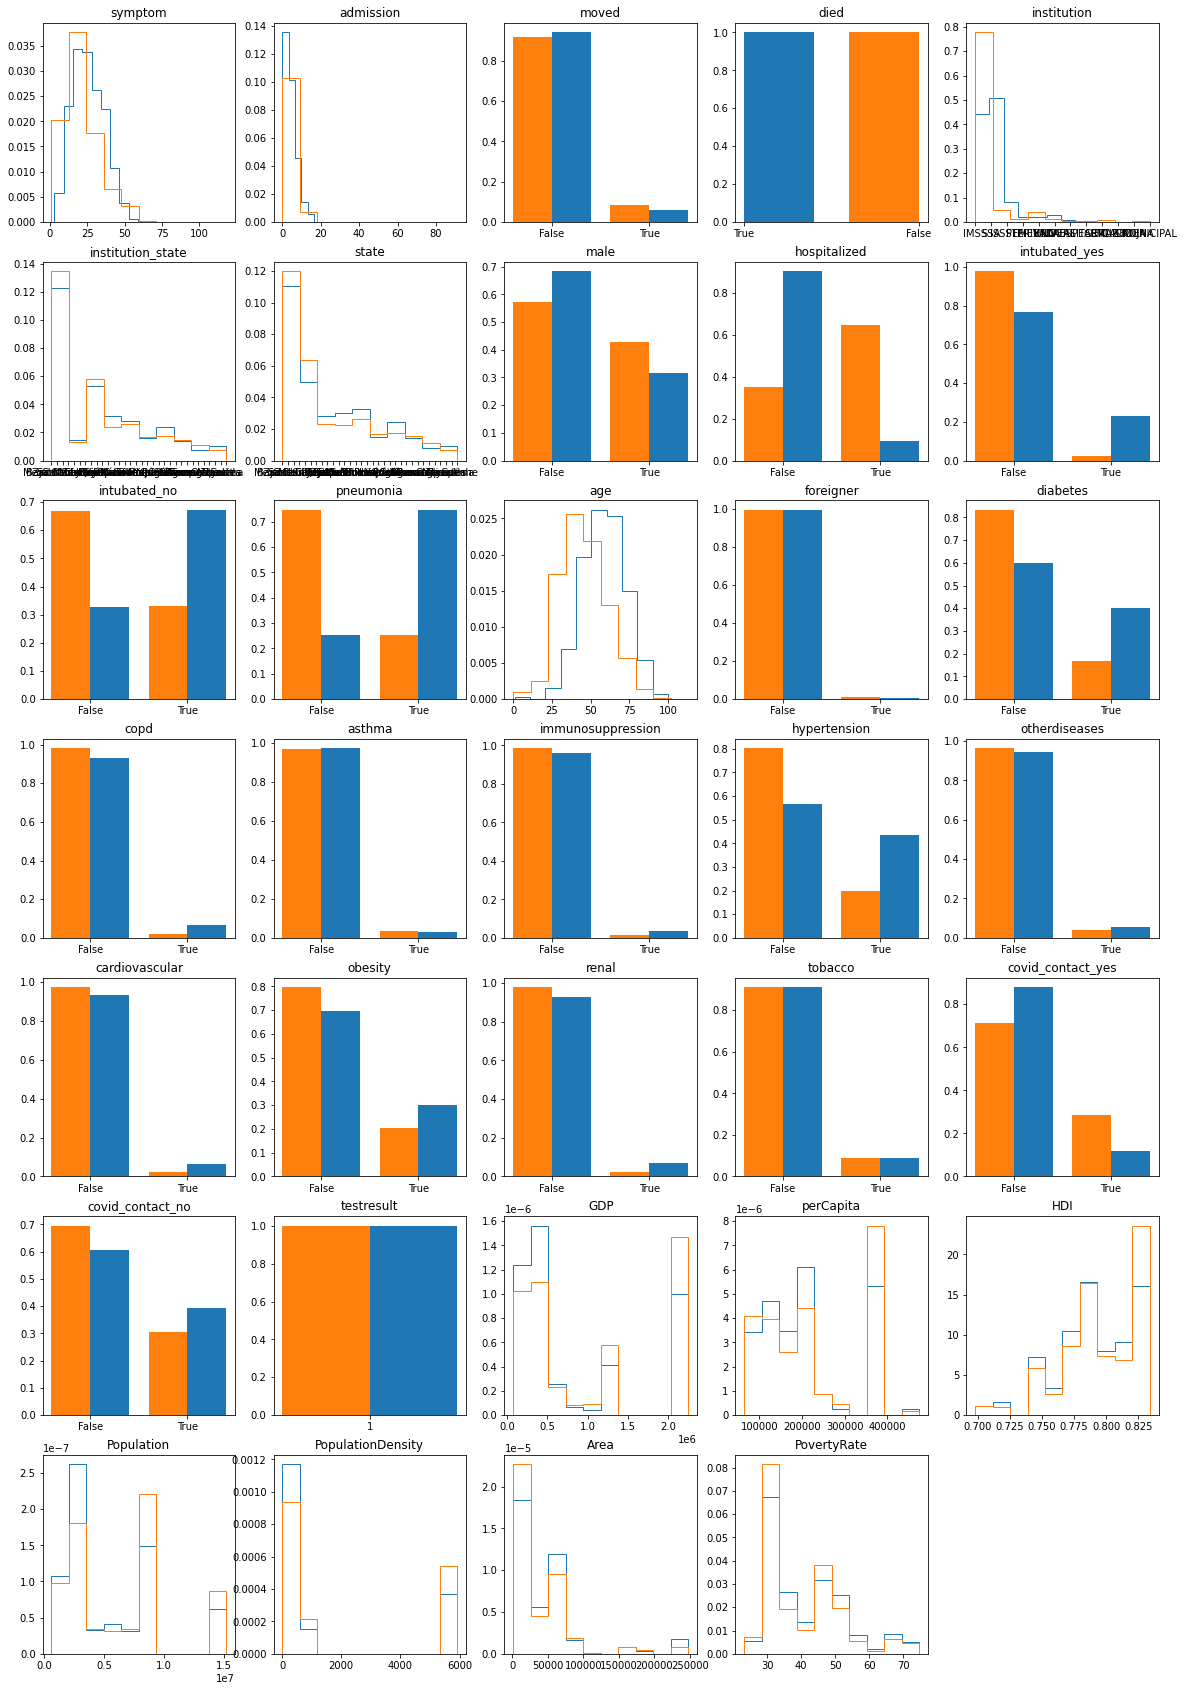

In [10]:
fig = plt.figure(figsize = (20,30))
for i in range(0,len(df.columns)):
    plt.subplot(7,5,i+1)
    value_counts_pos = df[(df.testresult==1) & (df.died==True)].iloc[:,i].value_counts().sort_index()  / len(df[(df.testresult==1) & (df.died==True)])
    value_counts_neg = df[(df.testresult==1) & (df.died==False)].iloc[:,i].value_counts().sort_index() / len(df[(df.testresult==1) & (df.died==False)])
    plt.title(df.columns[i])
    if len(value_counts_neg) < 10 :
        plt.bar(value_counts_pos.index.astype(str),value_counts_pos,align="edge", width = .4)
        plt.bar(value_counts_neg.index.astype(str),value_counts_neg,align="edge", width = -.4)
    else:
        plt.hist(df[(df.testresult==1) & (df.died==True)].iloc[:,i].dropna(), histtype = "step" ,density=True)
        plt.hist(df[(df.testresult==1) & (df.died==False)].iloc[:,i].dropna(), histtype = "step" ,density=True)

In [11]:
pd.concat([df.groupby('died').mean().T,df[df.testresult==1].groupby('died').mean().T],axis=1,keys=['all','positive'])

all                    positive              
died                      False         True          False         True 
symptom            2.312020e+01  2.559749e+01  2.140713e+01  2.561924e+01
admission          3.548983e+00  3.853958e+00  4.203652e+00  4.218437e+00
moved              6.737110e-02  5.739175e-02  8.341549e-02  5.971944e-02
male               4.957764e-01  3.517807e-01  4.272794e-01  3.158317e-01
hospitalized       7.591988e-01  8.301307e-02  6.464915e-01  9.498998e-02
intubated_yes      1.238997e-02  2.126569e-01  2.156115e-02  2.324649e-01
intubated_no       2.281352e-01  7.043300e-01  3.316902e-01  6.725451e-01
pneumonia          1.631593e-01  7.263643e-01  2.547902e-01  7.466934e-01
age                4.148835e+01  5.868486e+01  4.534489e+01  5.895752e+01
foreigner          1.191685e-02  5.636690e-03  8.958807e-03  6.012024e-03
diabetes           1.244616e-01  4.007174e-01  1.666595e-01  3.995992e-01
copd               2.255231e-02  8.660005e-02  2.023233e-02  6.733467e-02
asthma             4.466107e-02  2.792724e-02  3.399203e-02  2.885772e-02
immunosuppression  2.249317e-02  5.508583e-02  1.577436e-02  3.767535e-02
hypertension       1.640858e-01  4.342813e-01  1.982940e-01  4.352705e-01
otherdiseases      4.592274e-02  8.198821e-02  3.746410e-02  5.531062e-02
cardiovascular     2.841710e-02  8.403792e-02  2.511895e-02  6.332665e-02
obesity            1.597784e-01  2.659493e-01  2.026233e-01  3.030060e-01
renal              2.128079e-02  9.095568e-02  2.108963e-02  7.134269e-02
tobacco            9.671473e-02  1.019728e-01  8.868790e-02  8.977956e-02
covid_contact_yes  3.188964e-01  9.736100e-02  2.875820e-01  1.202405e-01
covid_contact_no   3.229673e-01  3.756085e-01  3.051567e-01  3.947896e-01
testresult         1.926163e+00  1.418140e+00  1.000000e+00  1.000000e+00
GDP                9.968515e+05  8.123992e+05  1.083579e+06  8.496460e+05
perCapita          2.223862e+05  2.010809e+05  2.300488e+05  2.087992e+05
HDI                7.931798e-01  7.880120e-01  7.968252e-01  7.910220e-01
Population         6.277067e+06  5.595797e+06  6.579925e+06  5.524460e+06
PopulationDensity  1.632356e+03  1.229642e+03  2.029576e+03  1.407087e+03
Area               4.582005e+04  5.331992e+04  3.847511e+04  4.858516e+04
PovertyRate        3.887620e+01  4.097950e+01  3.895167e+01  4.042056e+01

In [12]:
# np.set_printoptions(precision=3, suppress=True, floatmode=None)
np.savetxt('states.txt' , np.array(df[df.testresult==1].groupby('institution_state')[['GDP', 'perCapita', 'HDI', 'Population','PopulationDensity', 'Area', 'PovertyRate']].mean()),
           delimiter = ',',
           fmt='%.3f')  #.mode()
df[df.testresult==1].groupby('institution_state')[['GDP', 'perCapita', 'HDI', 'Population','PopulationDensity', 'Area', 'PovertyRate']].mean()

,GDP,perCapita,HDI,Population,PopulationDensity,Area,PovertyRate
institution_state,,,,,,,
Aguascalientes,163567,209339,0.798,1184996,211.0,5618,37.8
Baja California,382383,190268,0.809,3155070,44.0,71446,30.2
Baja California Sur,97833,208833,0.805,637026,7.0,73922,31.0
Campeche,610623,474486,0.770,822441,14.9,57924,44.7
Chiapas,234618,64287,0.698,4796580,65.0,73289,74.7
Chihuahua,382604,183450,0.786,3406465,13.2,247455,35.3
Coahuila,454047,245682,0.797,2748391,18.0,151563,27.9
Colima,79809,165941,0.789,650555,116.0,5625,34.4
Durango,158956,140027,0.771,1632934,12.0,123451,50.1


In [13]:
X = pd.get_dummies( df[df.testresult==1] , columns = ['institution'] ).drop(columns=['died', 'institution_state', 'state','testresult','symptom'])  # institution_state, state
X["number_of_conditions**2"] = X.iloc[:,9:19].sum(axis = 1) ** 2
X["number_of_conditions*age"] = X.iloc[:,9:19].sum(axis = 1) * X['age']
y = df[df.testresult==1]['died']
X.head()

,admission,moved,male,hospitalized,intubated_yes,intubated_no,pneumonia,age,foreigner,diabetes,...,institution_MUNICIPAL,institution_NO ESPECIFICADO,institution_PEMEX,institution_PRIVADA,institution_SEDENA,institution_SEMAR,institution_SSA,institution_UNIVERSITARIO,number_of_conditions**2,number_of_conditions*age
0,1,False,False,True,False,False,False,29,False,False,...,0,0,0,0,0,0,0,0,0,0
1,0,False,False,False,False,True,False,64,False,False,...,0,0,0,0,0,0,0,0,25,320
15,1,False,False,False,False,True,False,45,False,False,...,0,0,0,0,0,0,1,0,0,0
28,3,False,False,True,False,False,False,45,False,False,...,0,0,0,0,0,0,0,0,0,0
29,2,False,True,True,False,False,False,35,False,False,...,0,0,0,0,0,0,0,0,1,35


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
column_names = X_train.columns
y.value_counts()

False    23329
True      2495
Name: died, dtype: int64

In [15]:
# Oversample or Undersample

In [16]:
poly = PolynomialFeatures(2 , interaction_only = True, include_bias = False)

columns_mask = X_train.columns.str.find("institution") == -1
print(X_train.columns[columns_mask == False])
columns_poly = X_train.columns[columns_mask]
columns_poly = columns_poly[1:21]
X_train_poly = X_train[ columns_poly ]
X_test_poly  = X_test[  columns_poly ]
print([c.title() for c in columns_poly])
X_train_poly = poly.fit_transform(X_train_poly)
X_test_poly  = poly.transform(X_test_poly)
pickle.dump(poly, open("flask_app/poly.plk", 'wb'))
columns_poly = ['-'.join(columns_poly[poly.powers_[i] == 1]) for i in range(len(poly.powers_))] 
X_train_poly = pd.DataFrame(X_train_poly,columns = columns_poly, index = X_train.index)
X_test_poly  = pd.DataFrame(X_test_poly,columns  = columns_poly, index = X_test.index)

Index(['institution_CRUZ ROJA', 'institution_ESTATAL', 'institution_IMSS',
       'institution_ISSSTE', 'institution_MUNICIPAL',
       'institution_NO ESPECIFICADO', 'institution_PEMEX',
       'institution_PRIVADA', 'institution_SEDENA', 'institution_SEMAR',
       'institution_SSA', 'institution_UNIVERSITARIO'],
      dtype='object')
['Moved', 'Male', 'Hospitalized', 'Intubated_Yes', 'Intubated_No', 'Pneumonia', 'Age', 'Foreigner', 'Diabetes', 'Copd', 'Asthma', 'Immunosuppression', 'Hypertension', 'Otherdiseases', 'Cardiovascular', 'Obesity', 'Renal', 'Tobacco', 'Covid_Contact_Yes', 'Covid_Contact_No']


In [17]:
X_train_poly.iloc[:,20:]
X_train_poly = pd.concat([X_train, X_train_poly.iloc[:,20:]],axis = 1)
X_test_poly.iloc[:,20:]
X_test_poly = pd.concat([X_test, X_test_poly.iloc[:,20:]],axis = 1)
print(X_test_poly.shape)
print( list((X_train_poly != 0).any(axis=0)) ) 
X_train_poly = X_train_poly.loc[:, (X_train_poly != 0).any(axis=0)] # remove any columns of all 0
columns_poly = X_train_poly.columns
X_test_poly = X_test_poly[columns_poly]

(5165, 232)
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True,

In [18]:
X_test_poly.shape

(5165, 227)

In [ ]:
[0,0]+[1,2]

In [19]:
standar_scaler = StandardScaler()
X_train = standar_scaler.fit_transform(X_train)
X_test = standar_scaler.transform(X_test)

standar_scaler_poly = StandardScaler()
X_train_poly = standar_scaler.fit_transform(X_train_poly)
X_test_poly = standar_scaler.transform(X_test_poly)
pickle.dump(standar_scaler, open("flask_app/poly_scaler.plk", 'wb'))

In [20]:
#Dummy
print ( f'accuracy:  {accuracy_score(y_pred = [False]*len(y_train)     ,y_true = y_train)}' )
# print ( f'precision:  {precision_score(y_pred = [False]*len(y_train) ,y_true = y_train)}' )
# print ( f'recall:  {recall_score(y_pred = [False]*len(y_train)       ,y_true = y_train )}' )
# print ( f'f1:  {f1_score(y_pred = [False]*len(y_train)               ,y_true = y_train )}' )
print("")

accuracy:  0.9033835132387821



In [21]:
accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score) # , zero_division = 0 does not work in out v of sklearn
roc_auc_scorer = make_scorer(roc_auc_score)

In [22]:
 def model_cv_scores(model,X,y,verbose = True):
    kf = StratifiedKFold(5, random_state = 1717 )
    cv = cross_validate(
        model,
        X = X,
        y = y,
        cv =kf,
        scoring={"accuracy" : accuracy_scorer,
                 "precision" :  precision_scorer,
                 "recall" :  recall_scorer,
                 "f1" :  f1_scorer,
                 "auc" : roc_auc_scorer},
        return_train_score = True,
        n_jobs = -1) 
    if verbose:
        print ( f'accuracy:  {np.mean( cv["test_accuracy"] )}' )
        print ( f'precision:  {np.mean( cv["test_precision"] )}' )
        print ( f'recall:  {np.mean( cv["test_recall"] )}' )
        print ( f'f1:  {np.mean( cv["test_f1"] )}' )
        print ( f'auc:  {np.mean( cv["test_auc"] )}' )
    return cv

In [23]:
score_df = pd.DataFrame()

In [24]:
from sklearn.utils.class_weight import compute_class_weight
compute_class_weight('balanced' ,[True, False] , y_train )

array([5.1751002 , 0.55347479])

In [25]:
%%capture --no-display

model = DummyClassifier()
cv = model_cv_scores(model,X_train,y_train, verbose = False);
score_df["Dummy stratified"] = [ np.mean(score) for score in cv.values()]

# model = DummyClassifier(strategy = "constant", constant = True)
# cv = model_cv_scores(model,X_train,y_train, verbose = False);
# score_df["Dummy True"] = [ np.mean(score) for score in cv.values()]

# model = DummyClassifier(strategy = "constant", constant = False)
# cv = model_cv_scores(model,X_train,y_train, verbose = False);
# score_df["Dummy False"] = [ np.mean(score) for score in cv.values()]

model_log = LogisticRegression(solver = 'lbfgs', C = 1 , class_weight = 'balanced')
cv = model_cv_scores(model_log,X_train,y_train, verbose = False);
score_df["Logistic"] = [ np.mean(score) for score in cv.values()]

model_log_poly = LogisticRegression(solver = 'lbfgs', C = 4 , class_weight = 'balanced')
cv = model_cv_scores(model_log_poly,X_train_poly,y_train, verbose = False);
score_df["Logistic poly"] = [ np.mean(score) for score in cv.values()]

model_nb = GaussianNB()
cv = model_cv_scores(model_nb,X_train,y_train, verbose = False);
score_df["Gaussian NB"] = [ np.mean(score) for score in cv.values()]

model_nb_poly = GaussianNB()
cv = model_cv_scores(model_nb_poly,X_train_poly,y_train, verbose = False);
score_df["Gaussian NB poly"] = [ np.mean(score) for score in cv.values()]

model_tree = DecisionTreeClassifier(max_depth = None, class_weight = None)
cv = model_cv_scores(model_tree,X_train,y_train, verbose = False);
score_df["Decision Tree"] = [ np.mean(score) for score in cv.values()]

model_tree_poly = DecisionTreeClassifier(max_depth = None, class_weight = None)
cv = model_cv_scores(model_tree_poly,X_train_poly,y_train, verbose = False);
score_df["Decision Tree poly"] = [ np.mean(score) for score in cv.values()]

model_forest = RandomForestClassifier(n_estimators = 100)
cv = model_cv_scores(model_forest,X_train,y_train, verbose = False);
score_df["Random Forest"] = [ np.mean(score) for score in cv.values()]

model_forest_poly = RandomForestClassifier(n_estimators = 100, ccp_alpha = 0.001 , class_weight = 'balanced')
cv = model_cv_scores(model_forest_poly,X_train_poly,y_train, verbose = False);
score_df["Random Forest poly"] = [ np.mean(score) for score in cv.values()]

# model = LinearSVC(C = 1) 
# cv = model_cv_scores(model,X_train,y_train, verbose = False);
# score_df["SVM linear"] = [ np.mean(score) for score in cv.values()]

# model = SVC(gamma = 'auto' , kernel = 'poly') #‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
# cv = model_cv_scores(model,X_train,y_train, verbose = False);
# score_df["SVM poly"] = [ np.mean(score) for score in cv.values()]

# model = SVC(gamma = 'auto' , kernel = 'rbf') 
# cv = model_cv_scores(model,X_train,y_train, verbose = False);
# score_df["SVM rbf"] = [ np.mean(score) for score in cv.values()]

# model = SVC(gamma = 'auto' , kernel = 'sigmoid') 
# cv = model_cv_scores(model,X_train,y_train, verbose = False);
# score_df["SVM sigmoid"] = [ np.mean(score) for score in cv.values()]

model = GradientBoostingClassifier(n_estimators = 100, max_depth = 3)
cv = model_cv_scores(model,X_train,y_train, verbose = False);
score_df["Gradient Boosting"] = [ np.mean(score) for score in cv.values()]

model = xgb.XGBClassifier()
cv = model_cv_scores(model,X_train,y_train, verbose = False);
score_df["xg boost"] = [ np.mean(score) for score in cv.values()]

score_df["metric"] = cv.keys()
score_df = score_df.set_index("metric")

In [26]:
def highlight_max(data, color='none'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'font-weight: bold; background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
score_df.style.apply(highlight_max, axis=1)

,Dummy stratified,Logistic,Logistic poly,Gaussian NB,Gaussian NB poly,Decision Tree,Decision Tree poly,Random Forest,Random Forest poly,Gradient Boosting,xg boost
metric,,,,,,,,,,,
fit_time,0.016194,0.557216,2.575747,0.054383,0.315698,0.128357,1.129028,1.744427,5.162101,5.583166,6.163972
score_time,0.011996,0.011196,0.015796,0.041185,0.081772,0.010198,0.013996,0.094569,0.116363,0.020592,0.030390
test_accuracy,0.822983,0.784646,0.770802,0.157123,0.731741,0.868338,0.867177,0.905852,0.744372,0.909579,0.904690
train_accuracy,0.825258,0.786050,0.777615,0.157873,0.735127,0.998645,0.998645,0.998608,0.748076,0.918135,0.958565
test_precision,0.087452,0.288820,0.278043,0.101981,0.243478,0.331610,0.326121,0.526353,0.261606,0.588387,0.513469
train_precision,0.095023,0.290969,0.288842,0.102287,0.248035,0.999746,0.999746,0.997599,0.266622,0.706069,0.945674
test_recall,0.088177,0.839678,0.858729,0.989480,0.825145,0.356203,0.351189,0.254014,0.901307,0.213944,0.265525
train_recall,0.094815,0.845190,0.890281,0.992234,0.839680,0.986223,0.986223,0.987976,0.917835,0.262273,0.605960
test_f1,0.087802,0.429770,0.420020,0.184904,0.374566,0.343337,0.338039,0.342204,0.405431,0.313354,0.349607


In [28]:
model_forest_poly.fit(X_train_poly,y_train)
feature_importances = pd.DataFrame()
feature_importances["feature"] = columns_poly
feature_importances["importance"] = model_forest_poly.feature_importances_
# feature_importances = dict( zip( columns_poly , list(model_forest_poly.feature_importances_)) )
# feature_importances
# plt.bar(columns_poly,model_forest_poly.feature_importances_)
#plt.hist(np.log(feature_importances[feature_importances["importance"] > 0]["importance"]),bins=25)
feature_importances = feature_importances.sort_values("importance", ascending = False)
pd.concat([feature_importances.head(20).reset_index(drop=True), feature_importances.tail(20).reset_index(drop=True)], axis=1)

,feature,importance,feature,importance
0,hospitalized,0.118517,foreigner-immunosuppression,0.0
1,hospitalized-age,0.096484,moved-asthma,0.0
2,pneumonia-age,0.095904,moved-otherdiseases,0.0
3,intubated_no-age,0.066711,asthma-covid_contact_yes,0.0
4,pneumonia,0.060068,male-foreigner,0.0
5,number_of_conditions*age,0.058653,foreigner-asthma,0.0
6,intubated_no,0.046824,asthma-renal,0.0
7,age,0.040587,asthma-obesity,0.0
8,male-hospitalized,0.035340,asthma-hypertension,0.0
9,intubated_yes-age,0.032771,asthma-immunosuppression,0.0


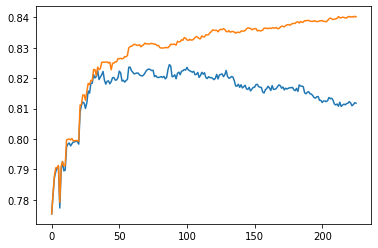

In [135]:
%%capture --no-display
auc_score = []
auc_score_train = []
model_log_poly = LogisticRegression(solver = 'lbfgs', C = 1 , class_weight = 'balanced')
for i in tqdm( range(1,len(columns_poly)) ):
    features = feature_importances.index[:i]
    _X = X_train_poly[:,features]
    cv = model_cv_scores(model_log_poly,_X,y_train, verbose = False);
    auc_score.append(np.mean(cv['test_auc']))
    auc_score_train.append(np.mean(cv['train_auc']))
plt.plot(auc_score)
plt.plot(auc_score_train)

In [102]:
%%capture --no-display

feature_select = SelectFromModel(model_forest_poly, threshold=-np.inf)

pipe = Pipeline([
  ('feature_selection', SelectFromModel(model_forest_poly, threshold=-np.inf)),
  ('classification', LogisticRegression(solver = 'lbfgs'))    
])

clf = GridSearchCV(estimator = pipe,
                   scoring = roc_auc_scorer,
                   cv = 5,
                   n_jobs = -1,
                   param_grid = {
                       'feature_selection__max_features' : range(60,121,10),
                       'classification__C' : 10**(np.linspace(-4,1,6)),
                       'classification__class_weight' : ['balanced'], #[{True : i} for i in np.linspace(7,14,8)]
                   },
                   verbose=1
                   )
clf.fit(X_train_poly, y_train);
pd.DataFrame(clf.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__C,param_classification__class_weight,param_feature_selection__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
84,6.275873,0.471642,0.035194,0.004364,10,balanced,90,"{'classification__C': 10.0, 'classification__c...",0.839908,0.843558,0.817464,0.846973,0.826083,0.834797,0.011203,1
52,4.483145,0.119439,0.024001,0.003572,0.1,balanced,90,"{'classification__C': 0.1, 'classification__cl...",0.844322,0.837501,0.823106,0.844144,0.821876,0.834190,0.009871,2
83,6.223977,0.592811,0.030790,0.011648,10,balanced,80,"{'classification__C': 10.0, 'classification__c...",0.842872,0.842855,0.818086,0.843315,0.822632,0.833952,0.011193,3
35,5.192358,0.159413,0.039999,0.020988,0.01,balanced,80,"{'classification__C': 0.01, 'classification__c...",0.838115,0.845469,0.820654,0.841035,0.823461,0.833747,0.009867,4
36,5.442335,0.091356,0.038598,0.016884,0.01,balanced,90,"{'classification__C': 0.01, 'classification__c...",0.833566,0.846091,0.821195,0.841730,0.826083,0.833733,0.009300,5


In [95]:
feature_select = SelectFromModel(model_forest_poly, threshold=-np.inf)

pipe = Pipeline([
  ('feature_selection', SelectFromModel(model_forest_poly, threshold=-np.inf)),
  ('classification', RandomForestClassifier())    
])

clf = GridSearchCV(estimator = pipe,
                   scoring = roc_auc_scorer,
                   cv = 5,
                   n_jobs = -1,
                   param_grid = {
#                         'feature_selection__max_features' : range(50,201,10),
                        'classification__n_estimators' : [100],
                        'classification__class_weight' : ['balanced'],
                        'classification__ccp_alpha' : 10**(np.linspace(-5,-1,13)),
#                            'max_features' : np.linspace(.1,1,10)                    
                   },
                   verbose=1
                   )
clf.fit(X_train_poly, y_train);
pd.DataFrame(clf.cv_results_).sort_values("rank_test_score").head(5)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  2.4min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__ccp_alpha,param_classification__class_weight,param_classification__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,8.457124,0.488029,0.119589,0.018852,0.001,balanced,100,"{'classification__ccp_alpha': 0.001, 'classifi...",0.821629,0.839285,0.810441,0.831035,0.827119,0.825902,0.009636,1
7,7.808265,0.092298,0.093004,0.007717,0.00215443,balanced,100,{'classification__ccp_alpha': 0.00215443469003...,0.824619,0.835538,0.805243,0.824075,0.822025,0.822300,0.009745,2
5,8.807951,0.170036,0.158653,0.024767,0.000464159,balanced,100,{'classification__ccp_alpha': 0.00046415888336...,0.807206,0.821272,0.791897,0.824567,0.821957,0.813380,0.012334,3
8,8.206337,0.226367,0.089368,0.009537,0.00464159,balanced,100,{'classification__ccp_alpha': 0.00464158883361...,0.802159,0.811618,0.798079,0.804846,0.805575,0.804456,0.004442,4
9,8.446700,0.223641,0.083591,0.007841,0.01,balanced,100,"{'classification__ccp_alpha': 0.01, 'classific...",0.789610,0.801623,0.788589,0.800212,0.786247,0.793256,0.006365,5


In [29]:
SelectFromModel(model_forest_poly, threshold=-np.inf, max_features = 4 , prefit = True).transform(X_train_poly)

array([[-1.20890693, -1.06748038,  1.75856313, -0.62289238],
       [-1.20890693, -1.06748038,  1.20528394,  1.38216963],
       [-1.20890693, -1.06748038,  0.98397226, -0.62289238],
       ...,
       [-1.20890693, -1.06748038,  0.91020171,  1.07369855],
       [-1.20890693, -1.06748038,  2.12741592, -0.62289238],
       [ 0.82719353,  0.51940209, -0.71275057, -0.62289238]])

C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 24.0, 'Predicted')

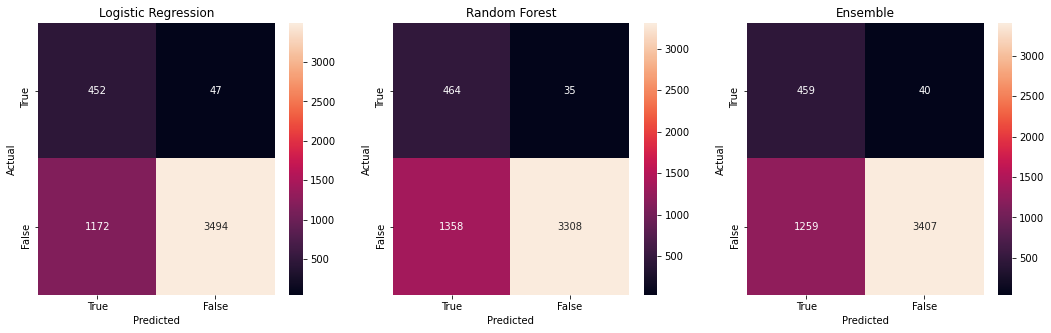

In [30]:
model_log_poly = LogisticRegression(solver = 'lbfgs', C = 4 , class_weight = 'balanced')
# SelectFromModel(model_forest_poly, threshold=-np.inf, max_features = 90, prefit = True )
model_log_poly = Pipeline([
  ('feature_selection', SelectFromModel(model_forest_poly, threshold=-np.inf, max_features = 90 )),
  ('classification', model_log_poly)    
])

model_log_poly.fit(X_train_poly,y_train)

model_forest_poly = RandomForestClassifier(n_estimators = 100, ccp_alpha = 0.001 , class_weight = 'balanced')
model_forest_poly.fit(X_train_poly,y_train)

fig = plt.figure(figsize = (18,5))
plt.subplot(1,3,1)
sns.heatmap( confusion_matrix(y_test, model_log_poly.predict_proba(X_test_poly)[:,1] >= .5 , labels=[True, False]) ,
            xticklabels = [True, False],
            yticklabels = [True, False],
            annot=True,
            fmt="g")
plt.title(label = "Logistic Regression")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(1,3,2)
sns.heatmap( confusion_matrix(y_test, model_forest_poly.predict_proba(X_test_poly)[:,1] >= .5 , labels=[True, False]) ,
            xticklabels = [True, False],
            yticklabels = [True, False],
            annot=True,
            fmt="g")
plt.title(label = "Random Forest")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(1,3,3)
sns.heatmap( confusion_matrix(y_test,
                              ( model_forest_poly.predict_proba(X_test_poly)[:,1] + 
                               model_log_poly.predict_proba(X_test_poly)[:,1] ) / 2 > 0.5,
                              labels=[True, False]) ,
            xticklabels = [True, False],
            yticklabels = [True, False],
            annot=True,
            fmt="g")
plt.title(label = "Ensemble")
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 24.0, 'Predicted')

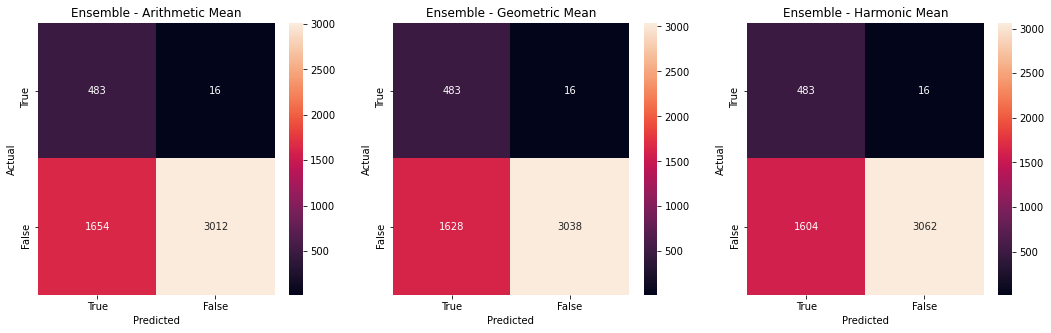

In [31]:
fig = plt.figure(figsize = (18,5))
plt.subplot(1,3,1)
sns.heatmap( confusion_matrix(y_test,
                              ( model_forest_poly.predict_proba(X_test_poly)[:,1] + 
                               model_log_poly.predict_proba(X_test_poly)[:,1] ) / 2 > 0.33,
                              labels=[True, False]) ,
            xticklabels = [True, False],
            yticklabels = [True, False],
            annot=True,
            fmt="g")
plt.title(label = "Ensemble - Arithmetic Mean")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(1,3,2)
sns.heatmap( confusion_matrix(y_test,
                              np.sqrt( model_forest_poly.predict_proba(X_test_poly)[:,1] * 
                               model_log_poly.predict_proba(X_test_poly)[:,1] ) > 0.33,
                              labels=[True, False]) ,
            xticklabels = [True, False],
            yticklabels = [True, False],
            annot=True,
            fmt="g")
plt.title(label = "Ensemble - Geometric Mean")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(1,3,3)
sns.heatmap( confusion_matrix(y_test,
                              2 / ( 1 / model_forest_poly.predict_proba(X_test_poly)[:,1] + 
                               1 / model_log_poly.predict_proba(X_test_poly)[:,1] )  > 0.33,
                              labels=[True, False]) ,
            xticklabels = [True, False],
            yticklabels = [True, False],
            annot=True,
            fmt="g")
plt.title(label = "Ensemble - Harmonic Mean")
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [32]:
logistic_coef = pd.DataFrame({"feature" : model_log_poly[0].transform([columns_poly])[0] , "coef" : model_log_poly[-1].coef_[0]})
feature_importances = feature_importances.merge(logistic_coef, on = 'feature',how = 'left')
feature_importances['feature'] = feature_importances['feature'].str.replace('_',' ').str.title()
feature_importances.to_csv('feature_importances.csv')

In [33]:
pickle.dump(model_log_poly, open("flask_app/model_log_poly.plk", 'wb'))
pickle.dump(model_forest_poly, open("flask_app/model_forest_poly.plk", 'wb'))

In [34]:
pd.concat([pd.DataFrame(model_log_poly.predict_proba(X_test_poly)) , pd.DataFrame(model_forest_poly.predict_proba(X_test_poly))], axis=1).head(20)

,0,1,0,1
0,0.989241,0.010759,0.960056,0.039944
1,0.665188,0.334812,0.437763,0.562237
2,0.974447,0.025553,0.933468,0.066532
3,0.991793,0.008207,0.937553,0.062447
4,0.178690,0.821310,0.228622,0.771378
5,0.478194,0.521806,0.560643,0.439357
6,0.362314,0.637686,0.359617,0.640383
7,0.166379,0.833621,0.211148,0.788852
8,0.549525,0.450475,0.389833,0.610167
9,0.957521,0.042479,0.945997,0.054003


In [35]:
pd.DataFrame({"Actual" : y_test,
"Logistic Regression" : model_log_poly.predict_proba(X_test_poly)[:,1] >= .5,
"Random Forest" : model_forest_poly.predict_proba(X_test_poly)[:,1] >= .5,
"Logistic Regression_proba" : model_log_poly.predict_proba(X_test_poly)[:,1],
"Random Forest_proba" : model_forest_poly.predict_proba(X_test_poly)[:,1],
"Ensemble": (model_forest_poly.predict_proba(X_test_poly)[:,1] + 
                               model_log_poly.predict_proba(X_test_poly)[:,1] ) / 2 > 0.5
}).to_csv('Predicted.csv')

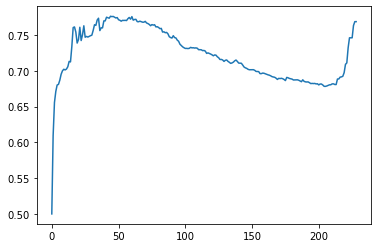

In [264]:
auc_score = []
for i in range(1,len(columns_poly)):
    features = feature_importances.index[:i]
    _X = X_train_poly[:,features]
    model_nb_poly = GaussianNB()
    cv = model_cv_scores(model_nb_poly,_X,y_train, verbose = False);
    auc_score.append(np.mean(cv['test_auc']))
plt.plot(auc_score)

,feature,importance
84,hospitalized_asthma,0.000099
64,male_foreigner,0.000096
188,asthma_cardiovascular,0.000089
158,foreigner_cardiovascular,0.000065
32,institution_MUNICIPAL,0.000058
161,foreigner_tobacco,0.000057
85,hospitalized_immunosuppression,0.000046
162,foreigner_covid_contact_yes,0.000044
185,asthma_immunosuppression,0.000036
81,hospitalized_foreigner,0.000034


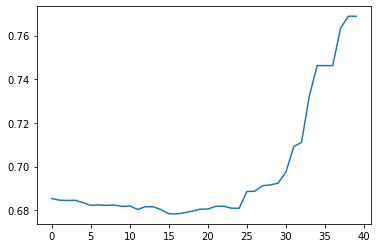

In [269]:
plt.plot(auc_score[-40:])
feature_importances.tail(20)

In [281]:
from sklearn.tree import plot_tree

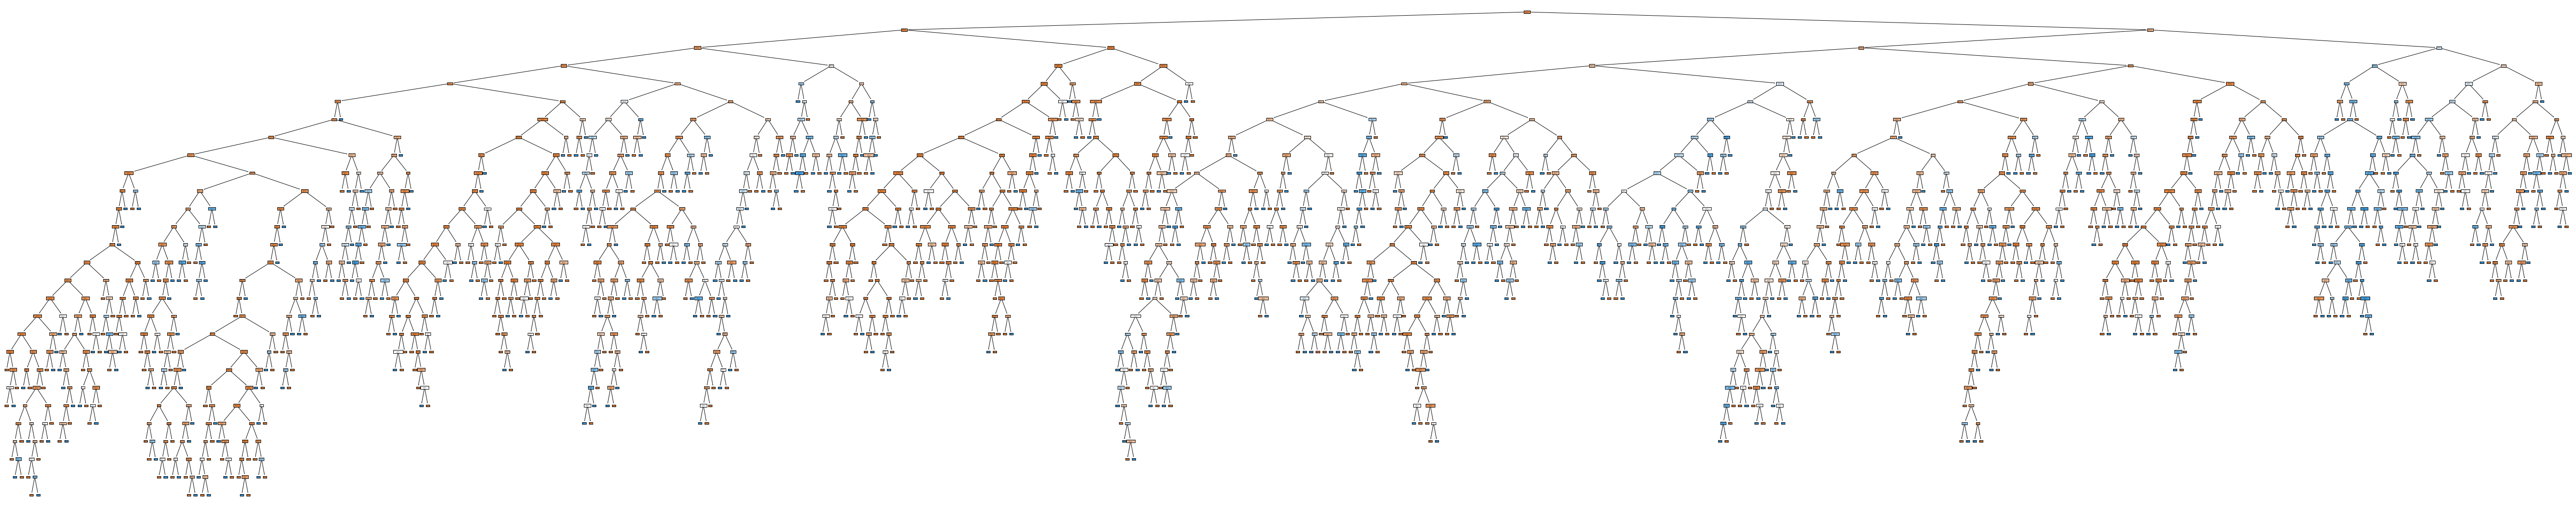

In [314]:
plt.figure(figsize=(100,20))
model_tree_poly.fit(X_train_poly,y_train)
plot_tree(model_tree_poly,max_depth=3,feature_names=columns_poly, filled=True);

In [47]:
def highlight_max(data, color='none'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'font-weight: bold; background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
score_df.style.apply(highlight_max, axis=1)

,Dummy stratified,Dummy True,Dummy False,Logistic,Gaussian NB,Decision Tree,Random Forest,SVM poly,SVM rbf,SVM sigmoid,Gradient Boosting,xg boost
metric,,,,,,,,,,,,
fit_time,0.032990,0.032988,0.029390,0.413266,0.059982,0.097966,1.304773,5.043698,5.437878,3.293417,3.472234,4.259304
score_time,0.020593,0.011996,0.030390,0.020194,0.059180,0.016795,0.327891,1.282687,2.297559,1.557002,0.045163,0.094170
test_accuracy,0.828287,0.094043,0.905957,0.917449,0.158193,0.874259,0.916247,0.910914,0.913543,0.888304,0.918501,0.914519
test_precision,0.083249,0.094043,0.000000,0.625622,0.099858,0.351214,0.620244,0.563580,0.666055,0.378539,0.637626,0.566326
test_recall,0.095812,1.000000,0.000000,0.305896,0.992019,0.396143,0.280322,0.235621,0.161339,0.293973,0.311480,0.382572
test_f1,0.092239,0.171919,0.000000,0.410439,0.181449,0.372196,0.386019,0.332148,0.259683,0.329979,0.418035,0.456534
test_auc,0.499485,0.500000,0.500000,0.643413,0.531828,0.660015,0.631289,0.608317,0.576482,0.621988,0.646496,0.676155


In [21]:
# drop rows with lots of 98
# change symptomdate to days since 1st case
# change admissiondate to days since symptomdate
# make catagories coumlms , died

#instution_state == state
#state population
#state GPD
#state HDI